<a href="https://colab.research.google.com/github/lbhagavan/stanford_LLM_Leela/blob/homework/Alex_Shreya_Sandeep_Ponnappa_Final_Demo_SalesCoPilot_ReAct_082924.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

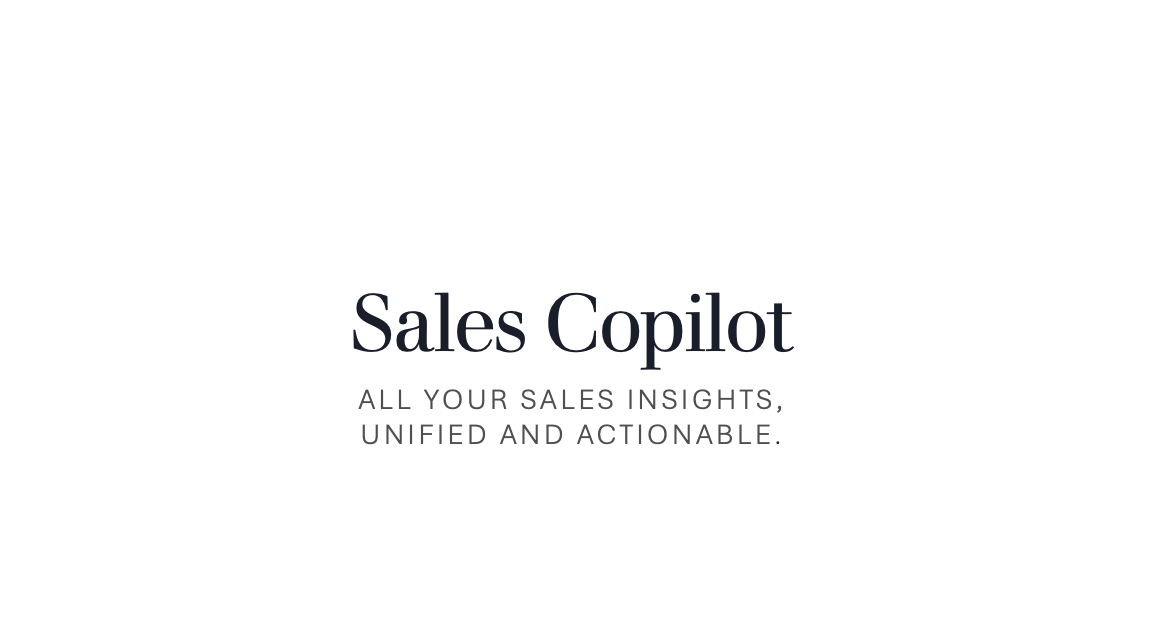

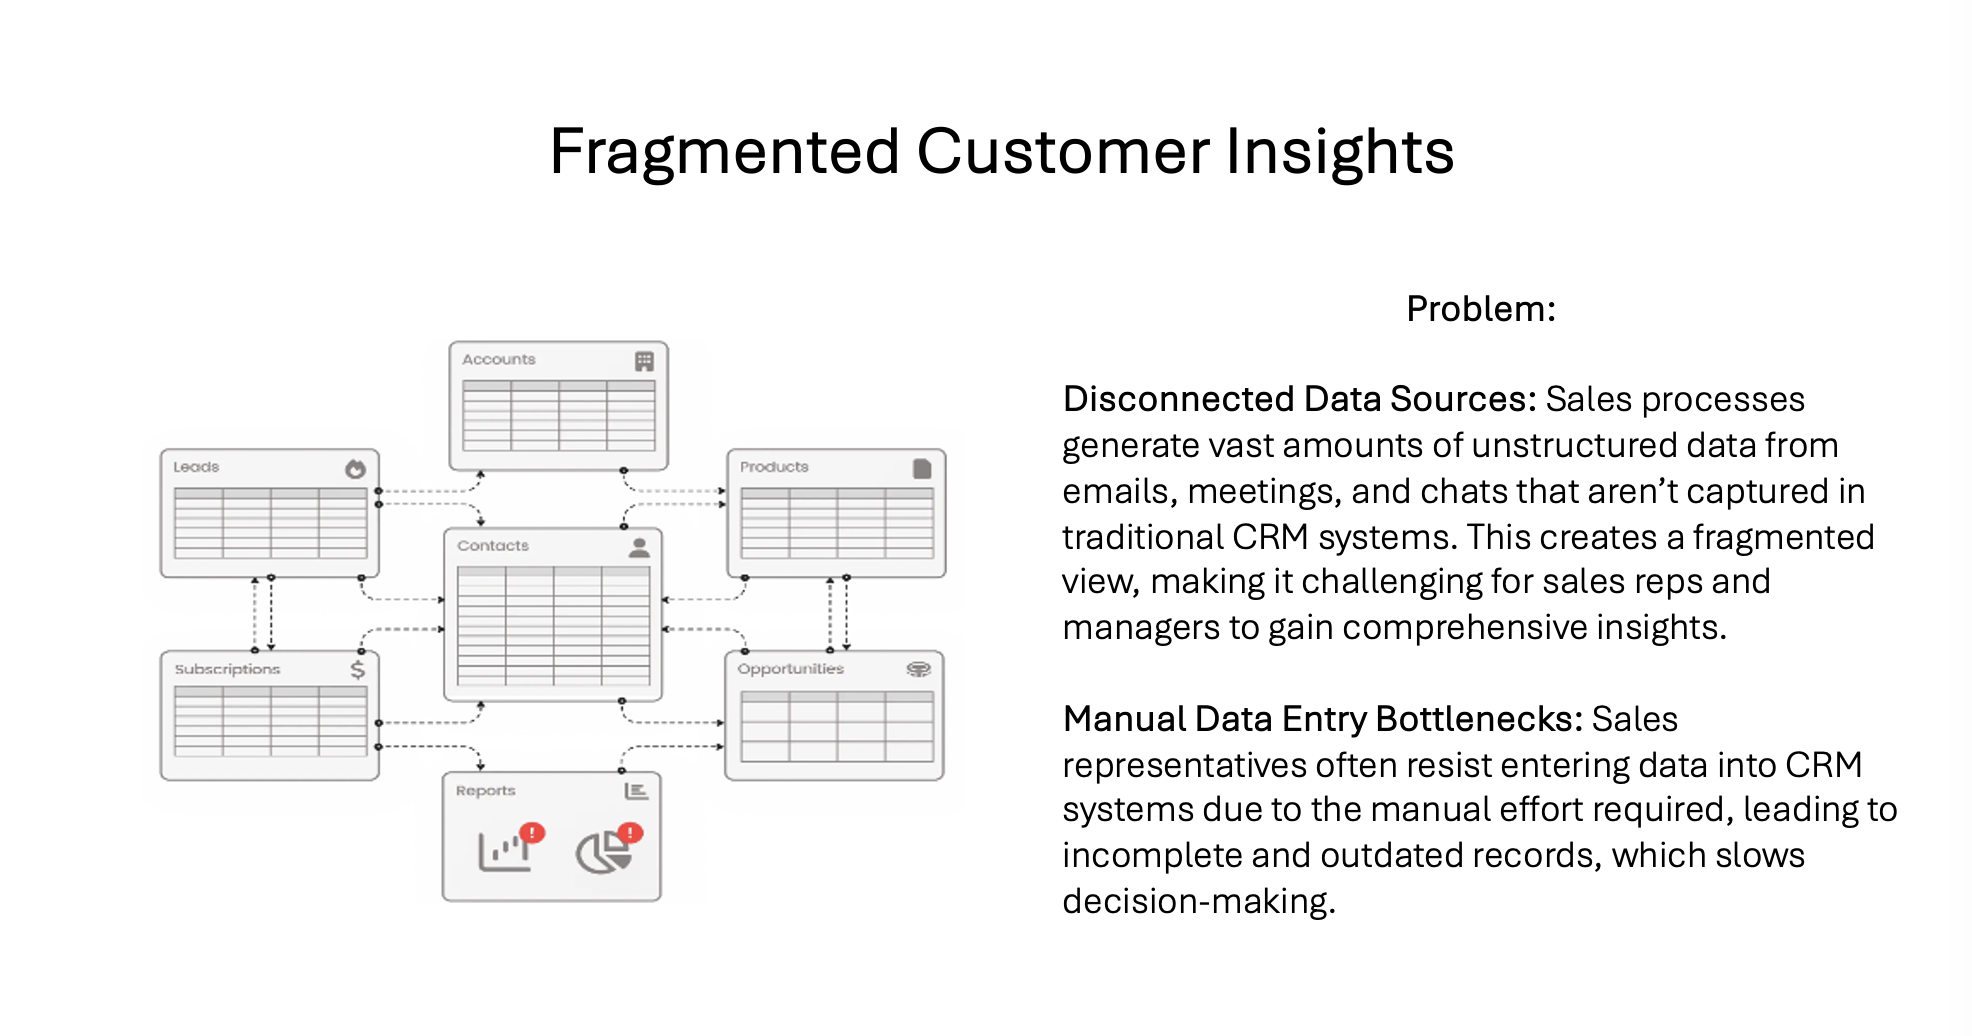

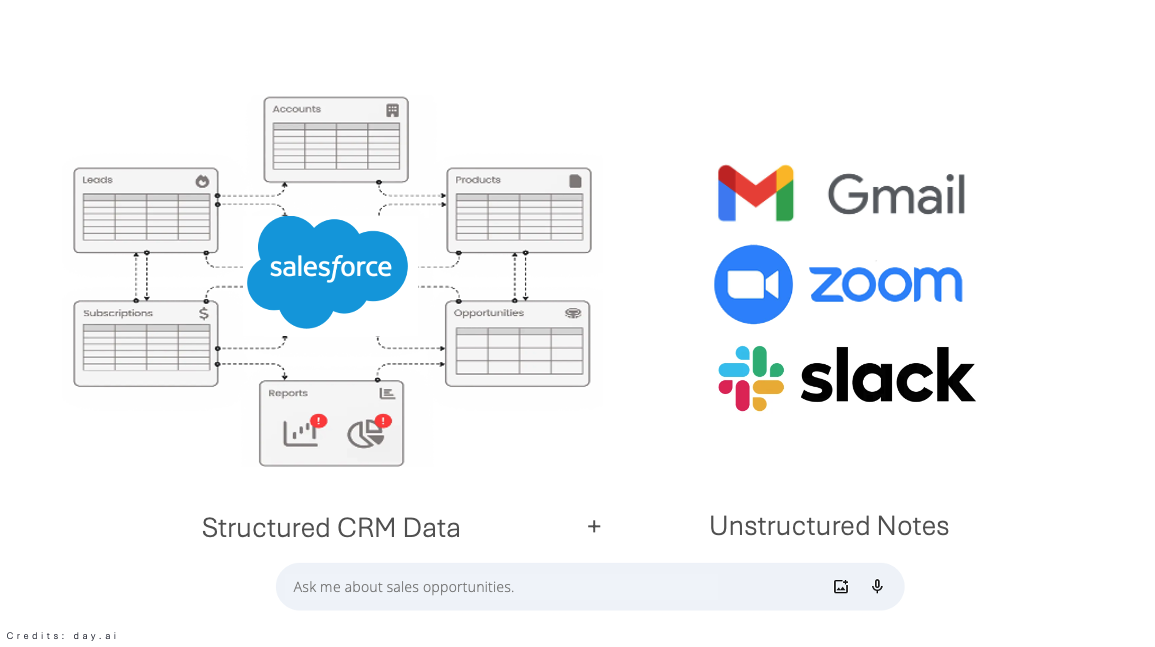

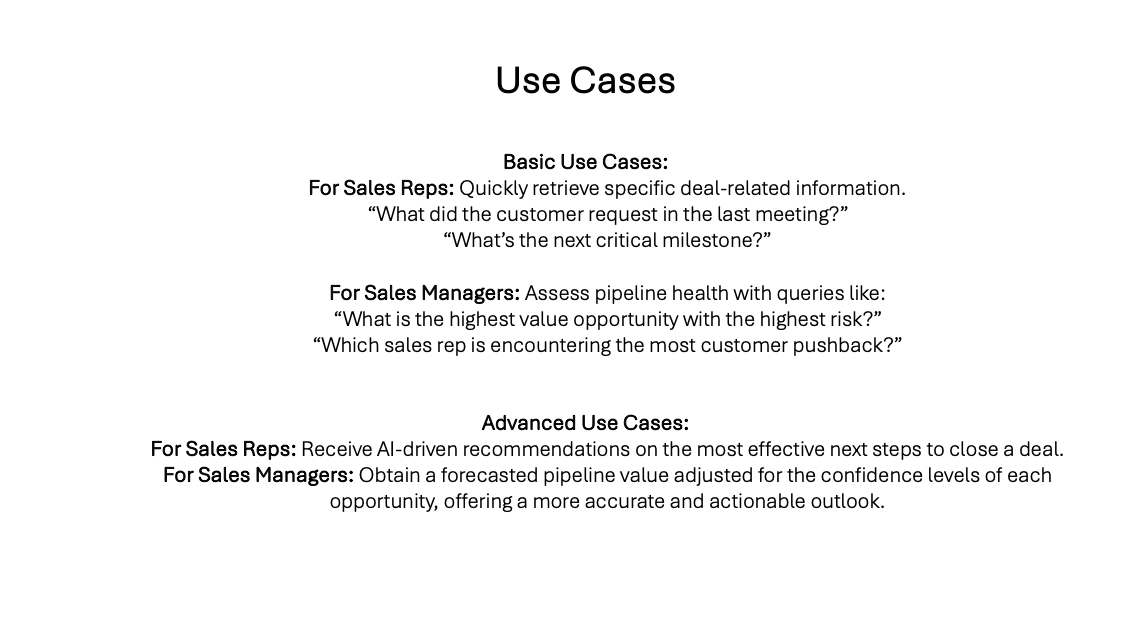

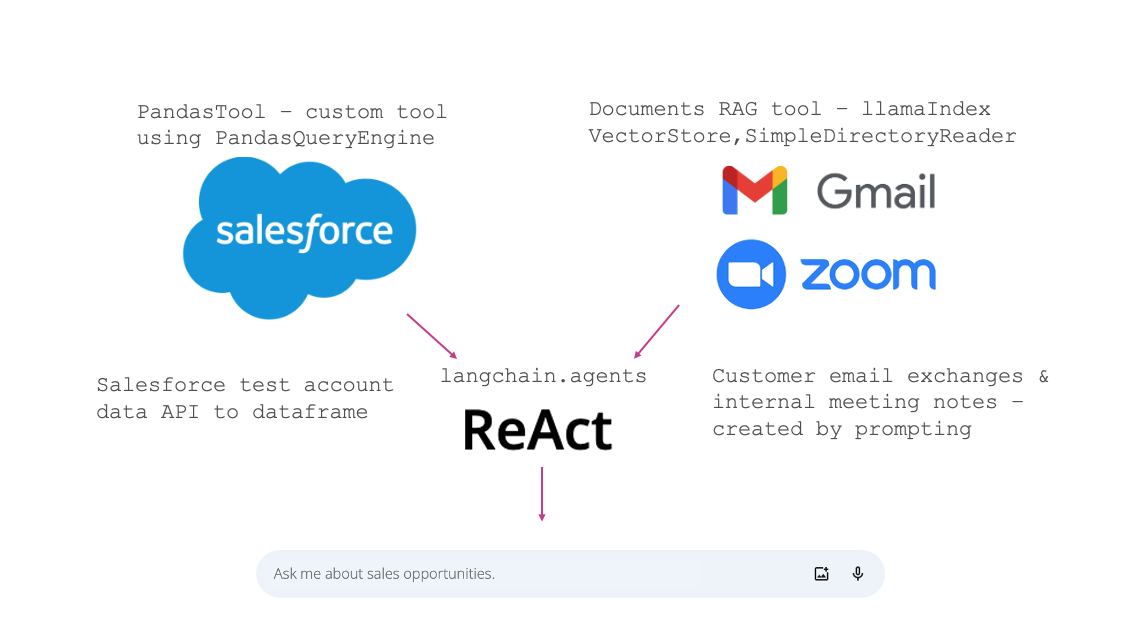

In [ ]:
!pip install openai
!pip install simple_salesforce
!pip install -q langchain-openai
!pip install -q openai
!pip install llama-index --upgrade

!pip install -U langchain-community

# Installing additional tools for query handling and LLM-based data interaction
!pip install -q llama-index llama-index-experimental

import openai
import os

from google.colab import userdata
open_ai_key = userdata.get('open_ai_key')

os.environ["OPENAI_API_KEY"] = userdata.get('open_ai_key')

In [ ]:
from simple_salesforce import Salesforce

from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.chat_models import ChatOpenAI

from langchain import hub
from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents.output_parsers import ReActSingleInputOutputParser
from langchain.tools.render import render_text_description

from llama_index.core import SimpleDirectoryReader, ServiceContext, VectorStoreIndex

from IPython.display import display, Markdown
import pandas as pd


**Salesforce integration and data enrichment**

In [ ]:
sf= Salesforce(
    username='salescopilot@stanford.ai',
    password='Salestech16',
    security_token='7MeFPnJLh8VMXkDo94XL7gio',
    domain='login')

opportunity_columns = sf.query_all("""
    SELECT
        Id, Name, Amount,
        AccountId, StageName, ExpectedRevenue, CloseDate,
        Probability, OwnerId, LeadSource,
        CreatedDate,
        ForecastCategory
    FROM Opportunity
""")

In [ ]:
# Convert records to DataFrames and drop the 'attributes' column
opportunities_df = pd.DataFrame(opportunity_columns['records']).drop(columns='attributes')
opportunities_df.sample(2)

,Id,Name,Amount,AccountId,StageName,ExpectedRevenue,CloseDate,Probability,OwnerId,LeadSource,CreatedDate,ForecastCategory
20,006ak000004gjrZAAQ,University of AZ Installations,100000.0,001ak00000UEdzcAAD,Proposal/Price Quote,75000.0,2024-05-11,75.0,005ak000007B2g5AAC,Employee Referral,2024-08-17T15:37:55.000+0000,Pipeline
6,006ak000004gjrLAAQ,United Oil Office Portable Generators,125000.0,001ak00000UEdzaAAD,Negotiation/Review,112500.0,2024-06-14,90.0,005ak000007B2g5AAC,None,2024-08-17T15:37:55.000+0000,Pipeline


In [ ]:
#Assigning owners to opportunities ensuring matching assignment for the ones with unstructured data present (emails, meeting notes)

import pandas as pd
import random
import numpy as np
from datetime import datetime, timedelta

## Owner name and email mapping:
owner_mapping = {
    '005ak000007B1b5AAC': ['Alice Johnson'],
    '005ak000007B2g5AAC': ['Eva Green'],
    '005ak000007C3h6AAC': ['Grace Black'],
    '005ak000007D4j7AAC': ['Ivy Smith']
}

# Mock emails for the names
contact_details = {
    'Alice Johnson': 'alice.johnson@salescrm.com',
    'Eva Green': 'eva.green@salescrm.com',
    'Grace Black': 'grace.black@salescrm.com',
    'Ivy Smith': 'ivy.smith@salescrm.com',
}

# Assign multiple unique Owner IDs to the DataFrame
unique_owner_ids = list(owner_mapping.keys())
opportunities_df['OwnerId'] = random.choices(unique_owner_ids, k=len(opportunities_df))

# Function to randomly assign a name for each OwnerId
def assign_random_name(owner_id):
    return random.choice(owner_mapping[owner_id])

# Assign Owner Names and Emails
opportunities_df['OwnerName'] = opportunities_df['OwnerId'].apply(assign_random_name)
opportunities_df['Email'] = opportunities_df['OwnerName'].apply(lambda name: contact_details[name])

## Add Close date and Created Date:
# Add CreatedDate randomly between Jan-Mar 2024
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 3, 31)
opportunities_df['CreatedDate'] = opportunities_df['CreatedDate'].apply(
    lambda _: start_date + timedelta(days=random.randint(0, (end_date - start_date).days))
)

# Function to generate a random date between two dates
def random_date(start_date, end_date):
    return start_date + timedelta(days=random.randint(0, (end_date - start_date).days))

# Define the date range for CloseDate
close_start_date = datetime(2024, 4, 1)
close_end_date = datetime(2024, 7, 31)

# Update CloseDate only if StageName is 'Closed-Won'
opportunities_df['CloseDate'] = opportunities_df.apply(
    lambda row: random_date(close_start_date, close_end_date)
    if row['StageName'] == 'Closed Won' else np.nan,
    axis=1
)

# Function to set StageName as 'Closed-Lost' with a probability of 0
def set_closed_lost(row):
    if random.random() < 0.07:  # 7% of the opportunities should be closed-lost
        row['StageName'] = 'Closed Lost'
        row['Probability'] = 0
        row['CloseDate'] = random_date(close_start_date, close_end_date)
        row['ForecastCategory'] = 'Closed'
    return row

# Apply the function to each row in the DataFrame
opportunities_df = opportunities_df.apply(set_closed_lost, axis=1)

# Add Customer Type
opportunities_df['CustomerType'] = opportunities_df['StageName'].apply(
    lambda x: random.choice(['Existing Customer Upgrade', 'New Customer Acquisition'])
)
#Add TopdealFlag
# Define the threshold
high_value_threshold = 200000

# Define the Topdealflag based on Amount and CustomerType
opportunities_df['Topdealflag'] = opportunities_df.apply(
    lambda row: True if row['Amount'] > high_value_threshold else False,
    axis=1
)

# Remove any duplicate names in the Name column
opportunities_df = opportunities_df.drop_duplicates(subset='Name')

# Delete rows where Name is 'United Oil Installations' or 'United Oil Emergency Generators'
opportunities_df = opportunities_df[~opportunities_df['Name'].isin(['United Oil Installations', 'United Oil Emergency Generators', 'United Oil Plant Standby Generators', 'United Oil Standby Generators', 'United Oil Refinery Generators', ])]

# Add a new column 'Product' with product tiers based on Amount and ExpectedRevenue
def assign_product_tier(row):
    if row['Amount'] > 500000 or row['ExpectedRevenue'] > 110000:
        return 'Sales Copilot Enterprise'
    elif row['Amount'] > 200000 or row['ExpectedRevenue'] > 50000:
        return 'Sales Copilot Premium'
    else:
        return 'Sales Copilot Basic'

opportunities_df['Product'] = opportunities_df.apply(assign_product_tier, axis=1)

# Arrange the columns in a logical order
columns_order = [
    'Id',              # Unique identifier for each opportunity
    'Name',            # Name or title of the opportunity
    'AccountId',       # Identifier for the related account (if available)
    'OwnerId',         # Identifier of the sales representative or manager
    'OwnerName',       # Name of the sales representative or manager
    'Email',           # Email of the sales representative or manager
    'Amount',          # Potential revenue associated with the opportunity
    'Probability',     # Likelihood of winning the opportunity
    'ExpectedRevenue', # Anticipated revenue (Amount * Probability)
    'StageName',       # Current stage of the opportunity
    'CloseDate',       # Expected or actual close date
    'CreatedDate',     # Date on which the opportunity was created
    'CustomerType',    # Type of customer (e.g., new or existing)
    'LeadSource',      # Source from which the opportunity originated
    'ForecastCategory',# Forecasting category
    'Topdealflag',     # Indicator of whether it's a top deal
    'Product'          # Sales Copilot product tier
]
# Reorder the DataFrame columns
opportunities_df = opportunities_df[columns_order]


In [ ]:
# # Define the additional rows as a DataFrame
additional_rows = pd.DataFrame({
     'Id': ['006ak000004gjrLAAQ', '006ak000004gjrIAAQ', '006ak000004gjrFAAQ', '006ak000004gjrGAAQ'],
     'Name': ['Delta Machineries', 'United Oil SLA', 'Dickenson Mobile Generators', 'Grand Hotels Kitchen Generator'],
     'AccountId': ['001ak00000UEdzaAAD', '001ak00000UEdzaAAD', '001ak00000UEdzYAAT', '001ak00000UEdzZAAT'],
     'OwnerId': ['005ak000007B2g5AAC', '005ak000007D4j7AAC', '005ak000007C3h6AAC', '005ak000007B1b5AAC'],
     'OwnerName': ['Eva Green', 'Ivy Smith', 'Grace Black', 'Alice Johnson'],
     'Email': ['eva.green@salescrm.com', 'ivy.smith@salescrm.com', 'grace.black@salescrm.com', 'alice.johnson@salescrm.com'],
     'Amount': [125000, 120000, 15000, 15000],
     'Probability': [90, 80, 10, 60],
     'ExpectedRevenue': [112500, 96000, 1500, 9000],
     'StageName': ['Negotiation/Review', 'Value Proposition', 'Qualification', 'Closed Lost'],
     'CloseDate': [pd.NaT, '2024-09-30', pd.NaT, pd.NaT],
     'CreatedDate': ['2024-01-28', '2024-02-11', '2024-02-03', '2024-01-08'],
     'CustomerType': ['Existing Customer Upgrade', 'New Customer Acquisition', 'Existing Customer Upgrade', 'Existing Customer Upgrade'],
     'LeadSource': [pd.NaT, 'Partner', 'Purchased List', pd.NaT],
     'ForecastCategory': ['Pipeline', 'Pipeline', 'Pipeline', 'Pipeline'],
     'Topdealflag': [True, True, False, False],
     'Product': ['Sales Copilot Enterprise', 'Sales Copilot Enterprise', 'Sales Copilot Basic', 'Sales Copilot Basic']
 })

# # Remove rows with the specified Opportunity IDs from the existing DataFrame
ids_to_remove = ['006ak000004gjrLAAQ', '006ak000004gjrIAAQ', '006ak000004gjrFAAQ', '006ak000004gjrGAAQ']
opportunities_df = opportunities_df[~opportunities_df['Id'].isin(ids_to_remove)]

# # Append the additional rows to the filtered DataFrame
opportunities_df = pd.concat([opportunities_df, additional_rows], ignore_index=True)

#opportunities_df.to_csv('opportunities_data.csv', index=False)

# # Display the updated DataFrame
opportunities_df

,Id,Name,AccountId,OwnerId,OwnerName,Email,Amount,Probability,ExpectedRevenue,StageName,CloseDate,CreatedDate,CustomerType,LeadSource,ForecastCategory,Topdealflag,Product
0,006ak000004gjrJAAQ,Edge Emergency Generator,001ak00000UEdzVAAT,005ak000007B2g5AAC,Eva Green,eva.green@salescrm.com,75000.0,100.0,75000.0,Closed Won,2024-06-23 00:00:00,2024-01-06 00:00:00,New Customer Acquisition,Word of mouth,Closed,False,Sales Copilot Premium
1,006ak000004gjrKAAQ,University of AZ Portable Generators,001ak00000UEdzcAAD,005ak000007C3h6AAC,Grace Black,grace.black@salescrm.com,50000.0,100.0,50000.0,Closed Won,2024-04-28 00:00:00,2024-03-31 00:00:00,Existing Customer Upgrade,Public Relations,Closed,False,Sales Copilot Basic
2,006ak000004gjrMAAQ,Express Logistics Standby Generator,001ak00000UEdzbAAD,005ak000007B1b5AAC,Alice Johnson,alice.johnson@salescrm.com,220000.0,100.0,220000.0,Closed Won,2024-04-07 00:00:00,2024-03-24 00:00:00,New Customer Acquisition,Trade Show,Closed,True,Sales Copilot Enterprise
3,006ak000004gjrNAAQ,GenePoint Standby Generator,001ak00000UEdzfAAD,005ak000007B1b5AAC,Alice Johnson,alice.johnson@salescrm.com,85000.0,100.0,85000.0,Closed Won,2024-06-17 00:00:00,2024-03-11 00:00:00,New Customer Acquisition,Partner,Closed,False,Sales Copilot Premium
4,006ak000004gjrOAAQ,Grand Hotels Guest Portable Generators,001ak00000UEdzZAAT,005ak000007D4j7AAC,Ivy Smith,ivy.smith@salescrm.com,250000.0,50.0,125000.0,Value Proposition,NaT,2024-02-20 00:00:00,New Customer Acquisition,Employee Referral,Pipeline,True,Sales Copilot Enterprise
5,006ak000004gjrPAAQ,Pyramid Emergency Generators,001ak00000UEdzXAAT,005ak000007B1b5AAC,Alice Johnson,alice.johnson@salescrm.com,100000.0,10.0,10000.0,Prospecting,NaT,2024-03-22 00:00:00,New Customer Acquisition,Phone Inquiry,Pipeline,False,Sales Copilot Basic
6,006ak000004gjrQAAQ,Express Logistics Portable Truck Generators,001ak00000UEdzbAAD,005ak000007D4j7AAC,Ivy Smith,ivy.smith@salescrm.com,80000.0,50.0,40000.0,Value Proposition,NaT,2024-03-22 00:00:00,New Customer Acquisition,External Referral,Pipeline,False,Sales Copilot Basic
7,006ak000004gjrRAAQ,GenePoint Lab Generators,001ak00000UEdzfAAD,005ak000007D4j7AAC,Ivy Smith,ivy.smith@salescrm.com,60000.0,60.0,36000.0,Id. Decision Makers,NaT,2024-03-02 00:00:00,New Customer Acquisition,None,Pipeline,False,Sales Copilot Basic
8,006ak000004gjrSAAQ,GenePoint SLA,001ak00000UEdzfAAD,005ak000007B1b5AAC,Alice Johnson,alice.johnson@salescrm.com,30000.0,100.0,30000.0,Closed Won,2024-06-19 00:00:00,2024-02-18 00:00:00,New Customer Acquisition,Partner,Closed,False,Sales Copilot Basic
9,006ak000004gjrUAAQ,Edge Installation,001ak00000UEdzVAAT,005ak000007C3h6AAC,Grace Black,grace.black@salescrm.com,50000.0,0.0,50000.0,Closed Lost,2024-04-21 00:00:00,2024-02-23 00:00:00,New Customer Acquisition,Word of mouth,Closed,False,Sales Copilot Basic


In [ ]:
from llama_index.experimental.query_engine import PandasQueryEngine
from llama_index.core import PromptTemplate

df_salesforce = opportunities_df

structured_query_engine = PandasQueryEngine(df=df_salesforce, verbose=False)
df_salesforce.head()


,Id,Name,AccountId,OwnerId,OwnerName,Email,Amount,Probability,ExpectedRevenue,StageName,CloseDate,CreatedDate,CustomerType,LeadSource,ForecastCategory,Topdealflag,Product
0,006ak000004gjrJAAQ,Edge Emergency Generator,001ak00000UEdzVAAT,005ak000007B2g5AAC,Eva Green,eva.green@salescrm.com,75000.0,100.0,75000.0,Closed Won,2024-06-23 00:00:00,2024-01-06 00:00:00,New Customer Acquisition,Word of mouth,Closed,False,Sales Copilot Premium
1,006ak000004gjrKAAQ,University of AZ Portable Generators,001ak00000UEdzcAAD,005ak000007C3h6AAC,Grace Black,grace.black@salescrm.com,50000.0,100.0,50000.0,Closed Won,2024-04-28 00:00:00,2024-03-31 00:00:00,Existing Customer Upgrade,Public Relations,Closed,False,Sales Copilot Basic
2,006ak000004gjrMAAQ,Express Logistics Standby Generator,001ak00000UEdzbAAD,005ak000007B1b5AAC,Alice Johnson,alice.johnson@salescrm.com,220000.0,100.0,220000.0,Closed Won,2024-04-07 00:00:00,2024-03-24 00:00:00,New Customer Acquisition,Trade Show,Closed,True,Sales Copilot Enterprise
3,006ak000004gjrNAAQ,GenePoint Standby Generator,001ak00000UEdzfAAD,005ak000007B1b5AAC,Alice Johnson,alice.johnson@salescrm.com,85000.0,100.0,85000.0,Closed Won,2024-06-17 00:00:00,2024-03-11 00:00:00,New Customer Acquisition,Partner,Closed,False,Sales Copilot Premium
4,006ak000004gjrOAAQ,Grand Hotels Guest Portable Generators,001ak00000UEdzZAAT,005ak000007D4j7AAC,Ivy Smith,ivy.smith@salescrm.com,250000.0,50.0,125000.0,Value Proposition,NaT,2024-02-20 00:00:00,New Customer Acquisition,Employee Referral,Pipeline,True,Sales Copilot Enterprise


**Building custom tools for structured data (PandasTool) and unstructured documents - emails and meeting notes (DocumentsTool)**

In [ ]:
from langchain.tools import BaseTool, StructuredTool, tool

# Creating a query engine that will interact with the pandas DataFrame to perform queries

# Defining a custom tool for querying the pandas DataFrame using natural language
class PandasTool(BaseTool):
    name: str = "PandasTool"
    description: str = """
      Use this tool to collect and analyze a dataset using Pandas.
      """

    def _run(self, question_to_answer: str) -> str:
        context = self.pandas_query_engine(question_to_answer)
        return context

    def pandas_query_engine(self, question_to_answer: str) -> str:
        context = structured_query_engine.query(question_to_answer)
        return context

# Instantiating the PandasTool for later use by agents
pandas_tool = PandasTool()

In [ ]:
# Read documents from the specified directory and load a specific document
documents = SimpleDirectoryReader("./").load_data("Combined-documents-internal-external.pdf")

# Create a VectorStoreIndex object from the documents. This will involve processing the documents
# and creating a vector representation for each of them, suitable for semantic searching.
index = VectorStoreIndex.from_documents(documents)

# Convert the VectorStoreIndex object into a query engine. This query engine can be used to
# perform semantic searches on the index, matching natural language queries to the most relevant
# documents in the index.
document_query_engine = index.as_query_engine()


Loading files: 100%|██████████| 1/1 [00:05<00:00,  5.22s/file]


In [ ]:
# Defining a custom tool for searching the documents
class DocumentsTool(BaseTool):
    name: str = "DocumentsTool"
    description: str = """
      Use this tool to search the documents to find answers to questions or to summarize documents
      """

    def _run(self, question_to_answer: str) -> str:
        context = self.unstructured_query_engine(question_to_answer)
        return context

    def unstructured_query_engine(self, question_to_answer: str) -> str:
        context = document_query_engine.query(question_to_answer)
        return context

# Instantiating the DocumentsTool for later use by agents
documents_tool = DocumentsTool()

In [ ]:
from langchain_openai import ChatOpenAI

#  load the language model we're using to control the agent
llm = ChatOpenAI(model = "gpt-4",temperature=0)

llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7c7492ca6710>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7c7492ca4df0>, root_client=<openai.OpenAI object at 0x7c749337ae90>, root_async_client=<openai.AsyncOpenAI object at 0x7c7492ca66e0>, model_name='gpt-4', temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='')

In [ ]:
# load custom tools and a default tool
tools = [pandas_tool, documents_tool]

# initialize agent with the tools, language model, and the type of agent
agent = initialize_agent(tools,
                         llm=llm,
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                         verbose=False
                         )

<ipython-input-12-e0c731b9e8c0>:5: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 1.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  agent = initialize_agent(tools,


In [ ]:
print(agent.agent.llm_chain.prompt.template)

In [ ]:
#test of the RAG tool
response=agent.run("How's Ivy Smith describing the product to the customer?")
display(Markdown(str(response)))

Ivy Smith is describing the product to the customer by highlighting the benefits of their AI chatbots, such as custom integration into existing infrastructure, proven efficiency through case studies, and dedicated ongoing support from their technical team. She also addresses the customer's concerns about the practical application of the technology and the responsiveness of the support team.

In [ ]:
#test of the pandas tool
response=agent.run("What are the top 3 opportunities by value?")
display(Markdown(str(response)))

The top 3 opportunities by value are "Grand Hotels Generator Installations" with a value of 350000.0, "Grand Hotels Guest Portable Generators" with a value of 250000.0, and "Burlington Textiles Weaving Plant Generator" with a value of 235000.0.

**Start of the demo. Sales Manager prepares for the monthly review by looking at the customers/opportunities his team is engaged in.**

In [ ]:
response=agent.run("Which opportunities closed last month?")
display(Markdown(str(response)))

The opportunities that were closed last month are "Express Logistics Standby Generator", "GenePoint Standby Generator", "Edge SLA", and "Grand Hotels Generator Installations".

In [ ]:
response=agent.run("What's the total opportunity value in the pipeline forecast category?")
display(Markdown(str(response)))

The total opportunity value in the pipeline forecast category is 985000.0.

In [ ]:
response=agent.run("List the opportunity in the negotiation/review stage? For this opportunity, summarize the email exchange with the sales rep and the customer.")
display(Markdown(str(response)))

The opportunity in the negotiation/review stage is "Delta Machineries" owned by Eva Green. The email exchange between Delta Machineries and Eva Green from SalesCopilot regarding the integration of an AI chatbot solution showcases Delta Machineries' initial concerns about integration and ongoing support, followed by Eva Green's reassurances and the subsequent agreement to move forward with the project.

In [ ]:
response = agent.run("Show me all the opportunities flagged as topdeal.")
display(Markdown(str(response)))

The opportunities flagged as topdeal are:

1. Express Logistics Standby Generator
2. Grand Hotels Guest Portable Generators
3. Grand Hotels Generator Installations
4. Burlington Textiles Weaving Plant Generator
5. Grand Hotels Emergency Generators
6. Delta Machineries
7. United Oil SLA

In [ ]:
response=agent.run("Tell me more about the United Oil SLA opportunity? Who is the Sales representative and how well did they communicate with the customer?")
display(Markdown(str(response)))

Ivy Smith is the Sales Representative involved in the United Oil SLA opportunity. She effectively communicated with United Oil SLA, addressing their initial skepticism about the practical application of AI in their setup. After a demonstration of the AI chatbot technology tailored to their needs, United Oil SLA was impressed by its capabilities and its potential to integrate seamlessly with their systems. They appreciated the value it could bring to their operations and were open to further discussions and potentially partnering with SalesCopilot.

In [ ]:
response=agent.run("How much is the discount the sales team proposed in the pricing discussion for that opportunity?")
display(Markdown(str(response)))

The proposed discount was 50%.

In [ ]:
response=agent.run("For that opportunity, what were the next steps agreed with pricing?")
display(Markdown(str(response)))

The next steps agreed with pricing for the opportunity were to explore alternative pricing models, develop a revised proposal, continue negotiations with United Oil SLA to find a mutually agreeable pricing solution, and monitor the customer's response to adjust the strategy as needed.

In [ ]:
response=agent.run("List the opportunity in the qualification stage. For this opportunity, summarize the internal prep meeting before the customer presentation.")
display(Markdown(str(response)))

The opportunity in the qualification stage is with Dickenson. The internal preparation meeting summary involved the Sales CoPilot team discussing their readiness to present the product to Dickenson. Grace Black expressed confidence in closing the deal, emphasizing the product's potential to enhance sales efficiency. Steve Right raised concerns about technical limitations and incomplete features, while Bryan Thomson stressed the importance of a strong sales pitch to address any reservations. Raj Goyal provided a technical perspective on the product's capabilities and integration with Dickenson's systems. The team agreed to focus on the product's core benefits, prepare a tailored presentation, and proceed with the meeting despite concerns about the product's readiness. Raj Goyal will be responsible for providing technical support during the meeting.

**Additional questions, if time permits.**

In [ ]:
response=agent.run("Are customers showing any frustration in any emails? If yes, who is the Sales rep?")
display(Markdown(str(response)))

Yes, customers are showing frustration in some emails. The sales rep associated with these emails is Grace Black.

In [ ]:
response=agent.run("Which salesperson has the most number of unclosed opportunities? Check their emails to see how I can coach them to improve their communication style.")
display(Markdown(str(response)))

Ivy Smith could improve her communication style by focusing more on understanding the customer's needs and challenges before proposing a solution. This could help her to better tailor her pitch and potentially increase her closing rate.

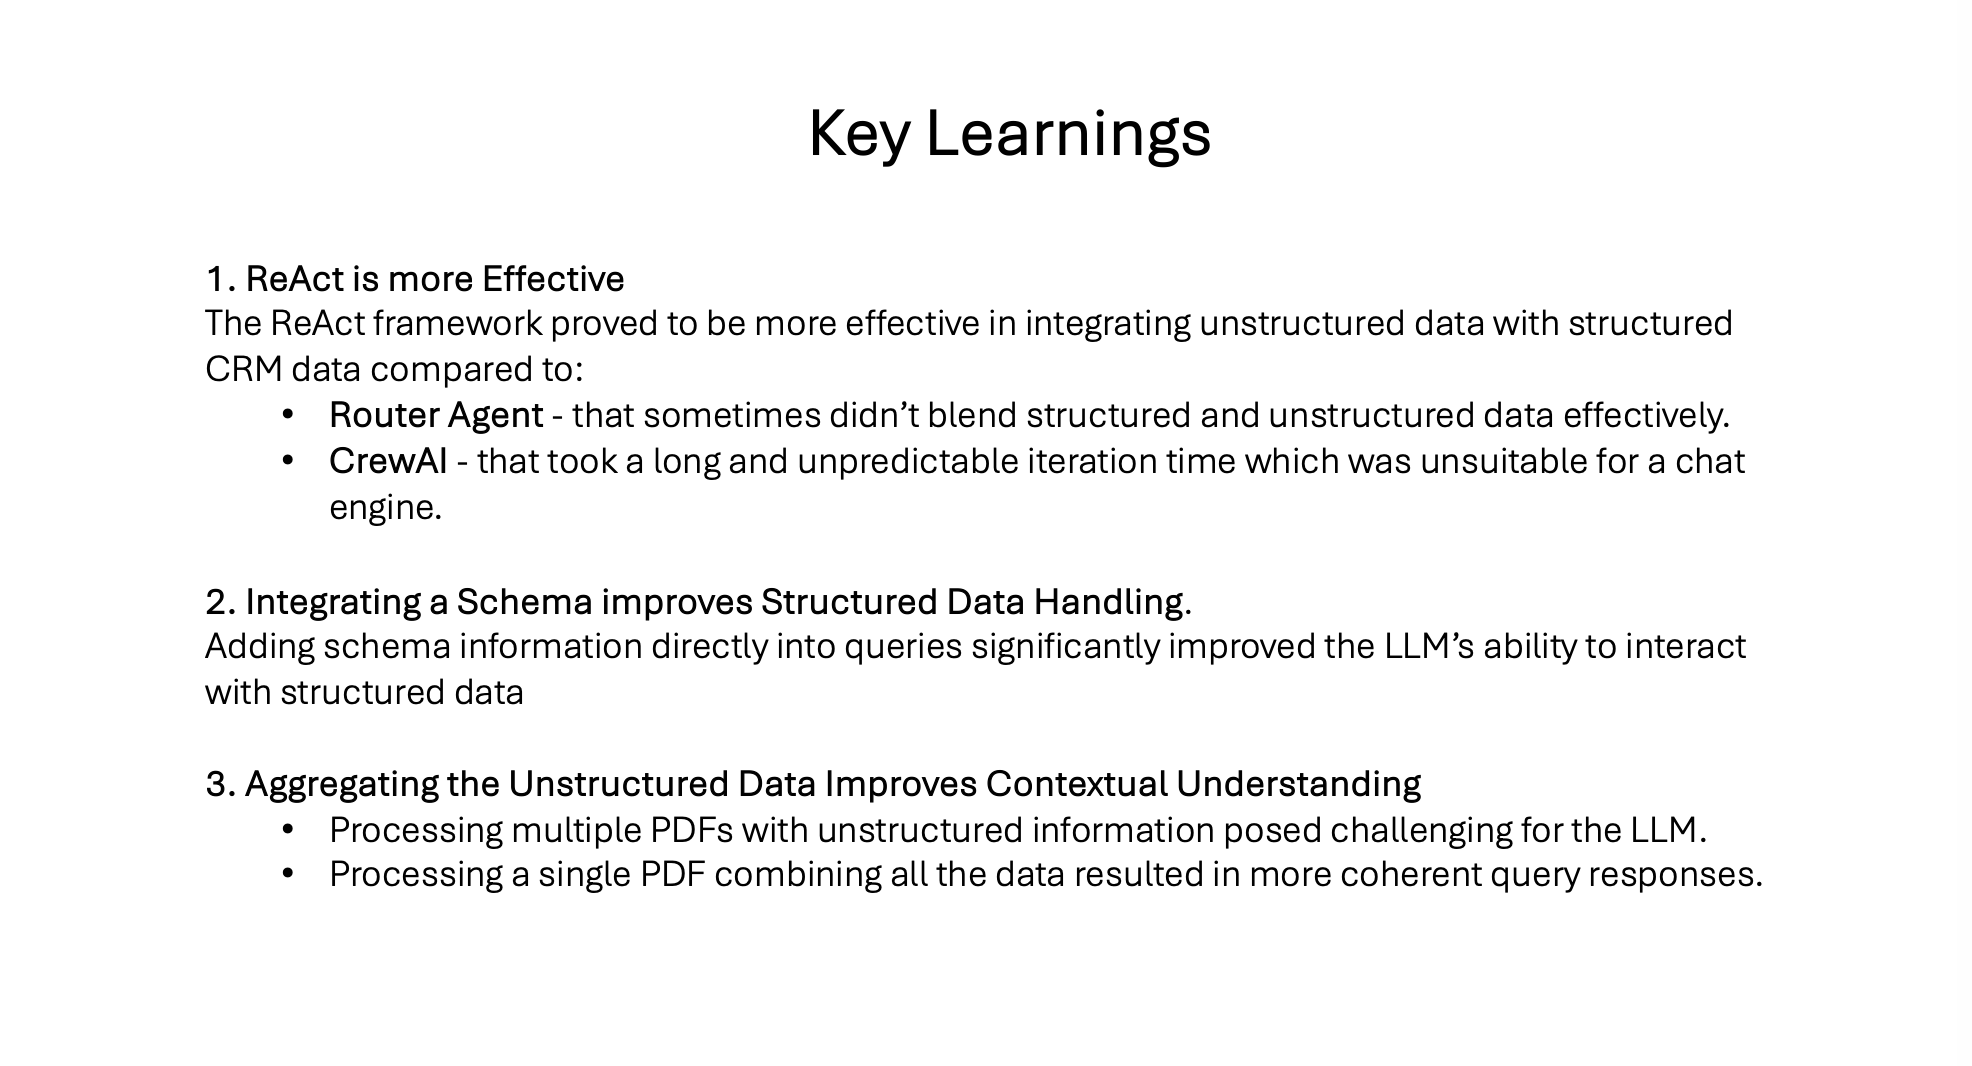

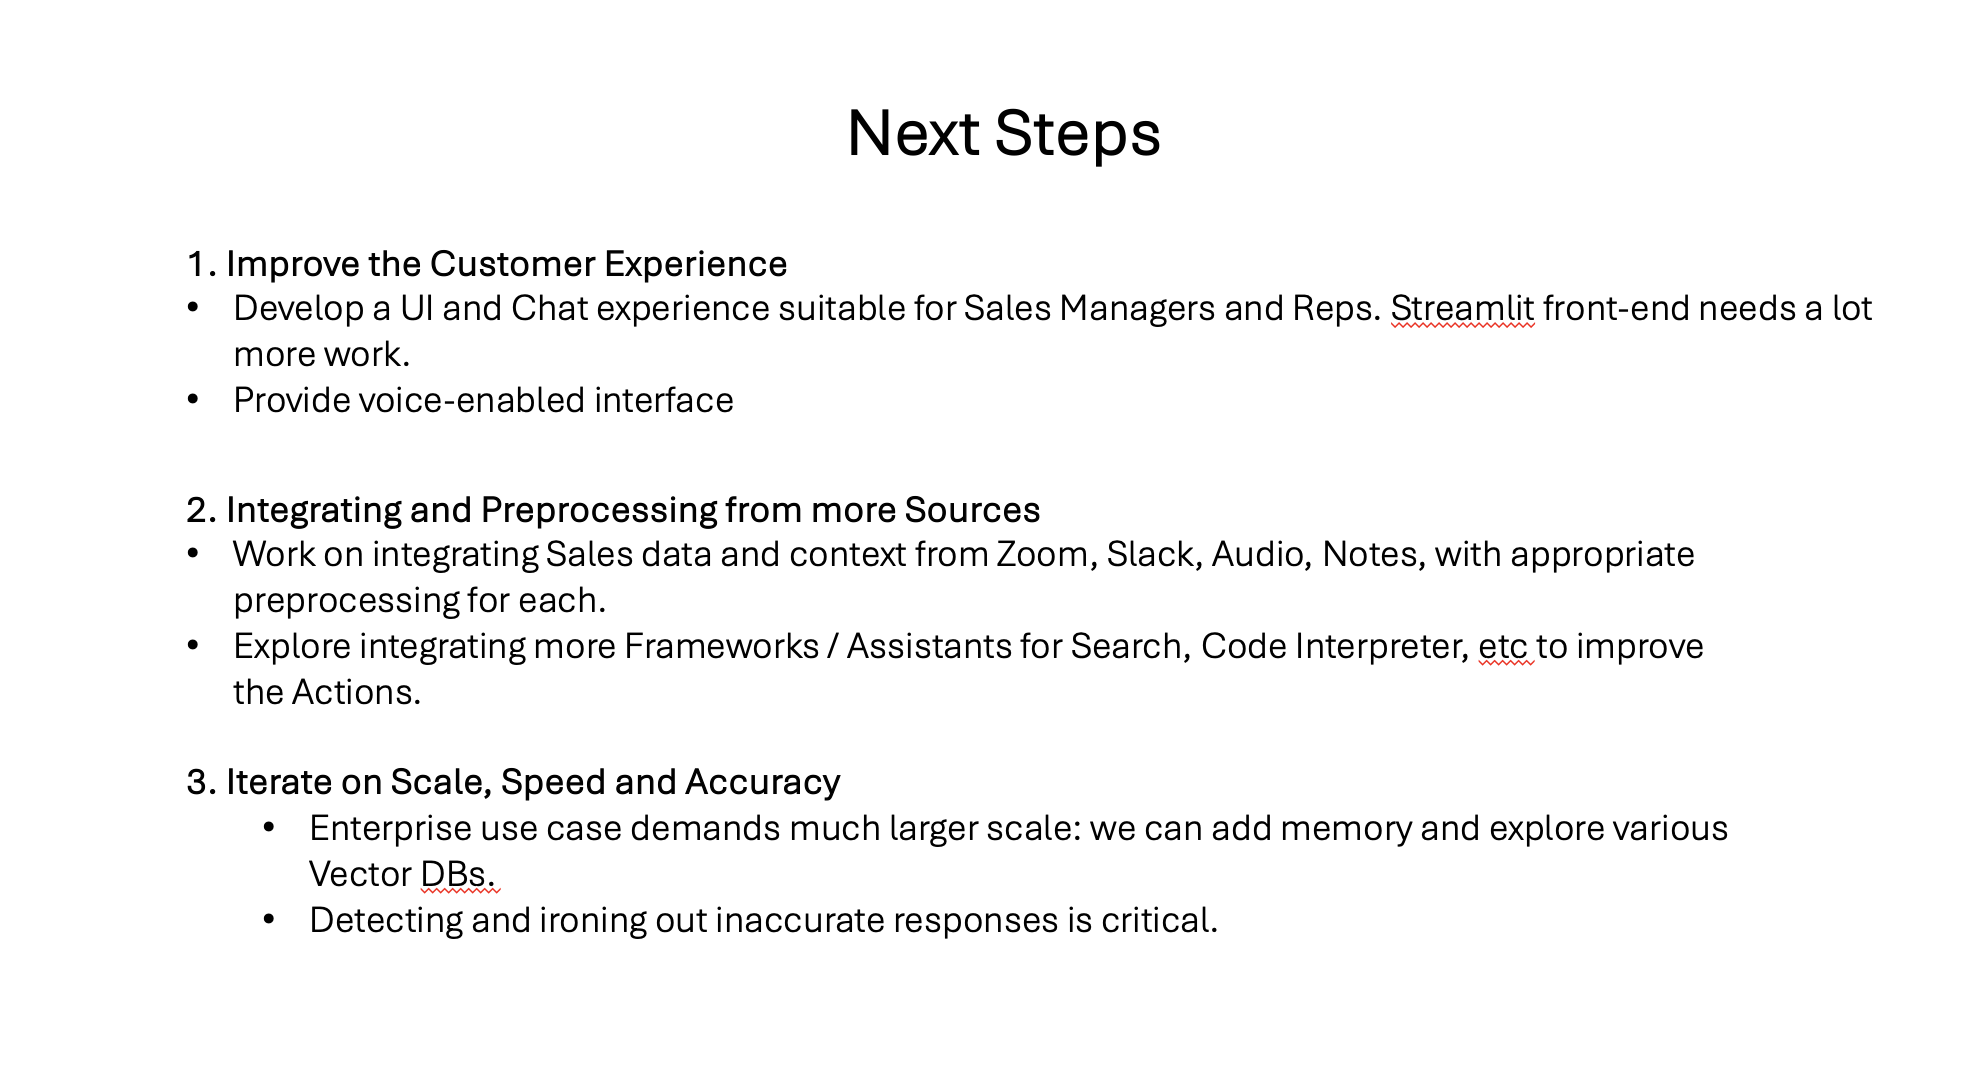

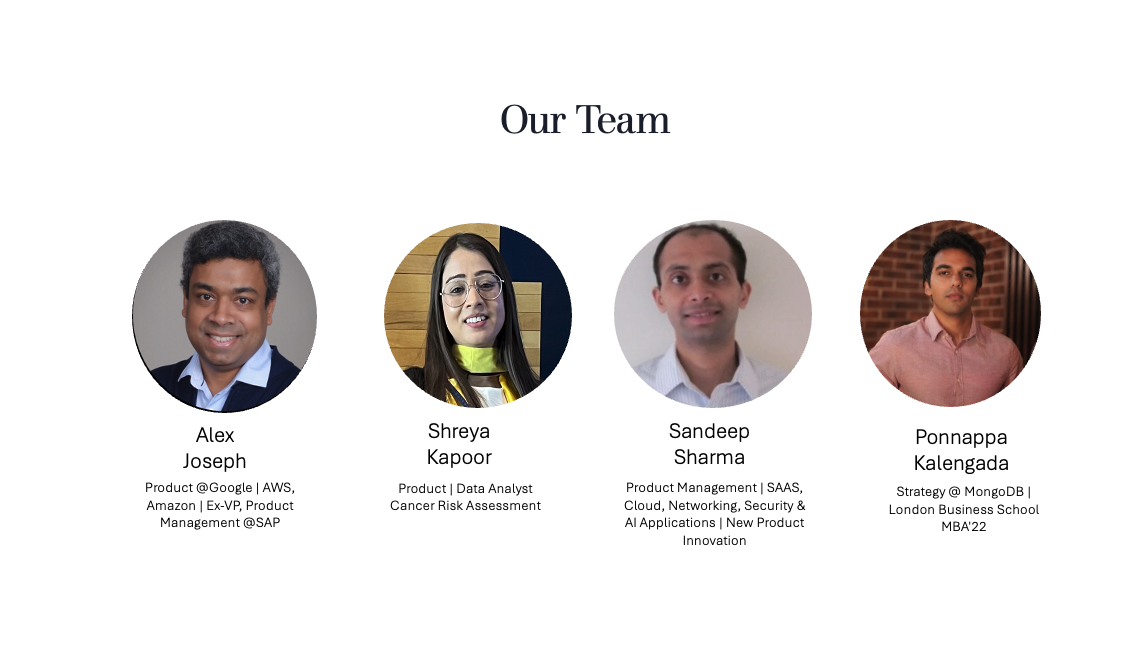